In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image, ImageFilter
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torchvision.models import ResNet18_Weights

from sklearn.cluster import KMeans
from skimage.measure import label
from skimage.measure import label, regionprops
from scipy.ndimage import binary_dilation

In [2]:
class Load_data(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith(('.TIF'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image

In [3]:
class Preprocess:
    def __call__(self, image):
        sample = np.array(image)
        sample = cv2.normalize(sample, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        processed_image = Image.fromarray(sample).convert('RGB')
        return processed_image

In [4]:
transform = transforms.Compose([
    Preprocess(),
    transforms.Resize((2048, 2048)),
    transforms.ToTensor(),
])

In [5]:
dataset = Load_data(root_dir='images/normal', transform=transform)
train_size = 9
test_size = 2
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train = DataLoader(train_dataset, batch_size=1, shuffle=True)
test = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [6]:
pretrained_encoder = models.vgg16(weights="IMAGENET1K_V1")
encoder = nn.Sequential(*list(pretrained_encoder.features.children())[:-1])

In [7]:
class Autoencoder(nn.Module):
    def __init__(self, encoder):
        super(Autoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Flatten for clustering
        return x

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
autoencoder = Autoencoder(encoder).to(device)

autoencoder.load_state_dict(torch.load("autoencoder_model.pth"))
autoencoder.eval()
print("Model loaded successfully")

Model loaded successfully and ready for inference!


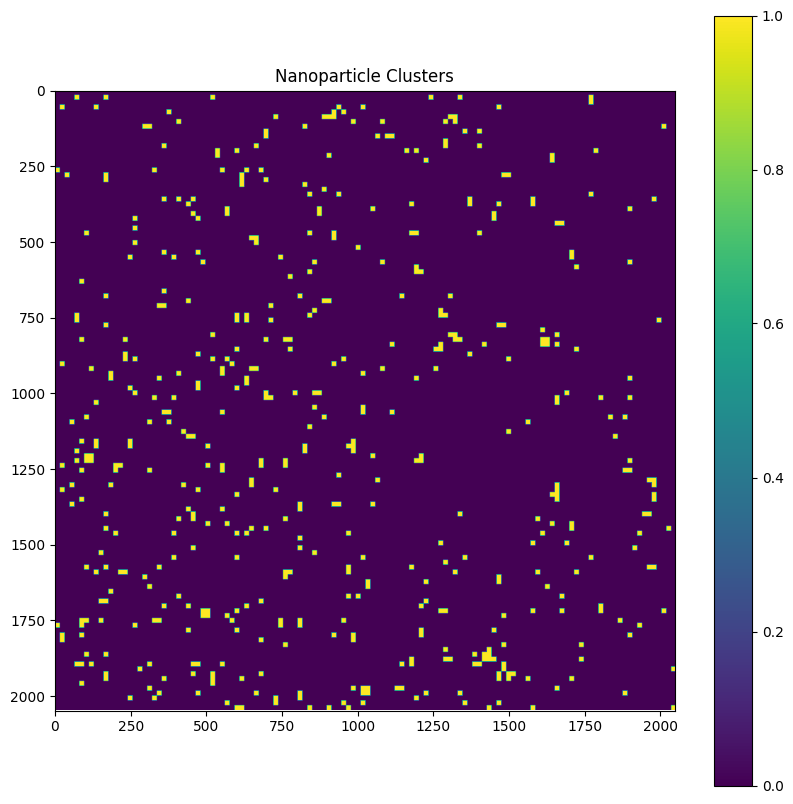

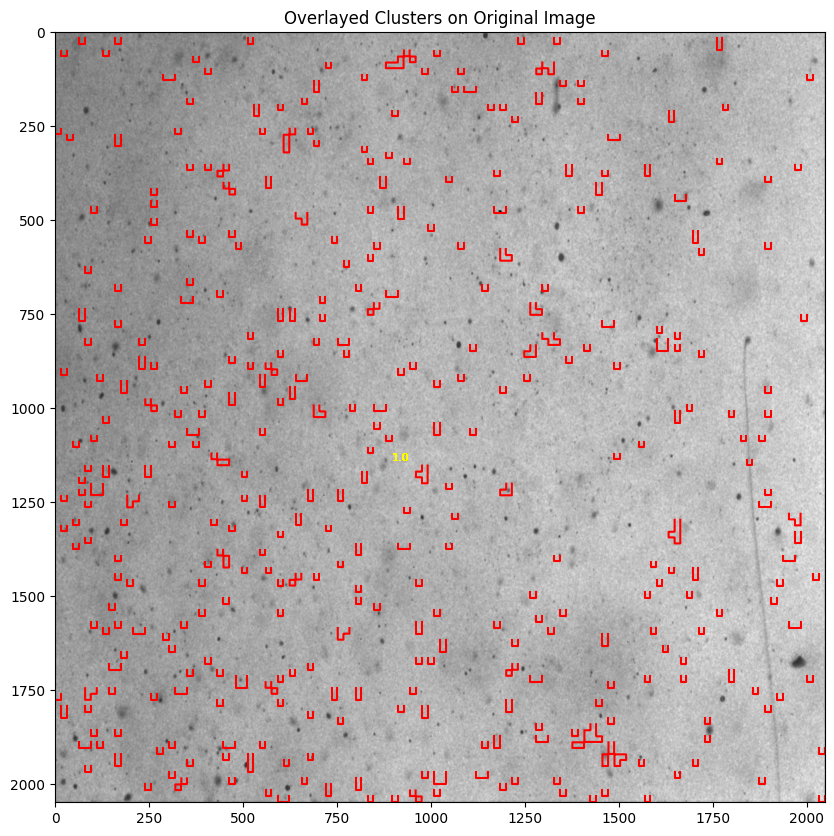

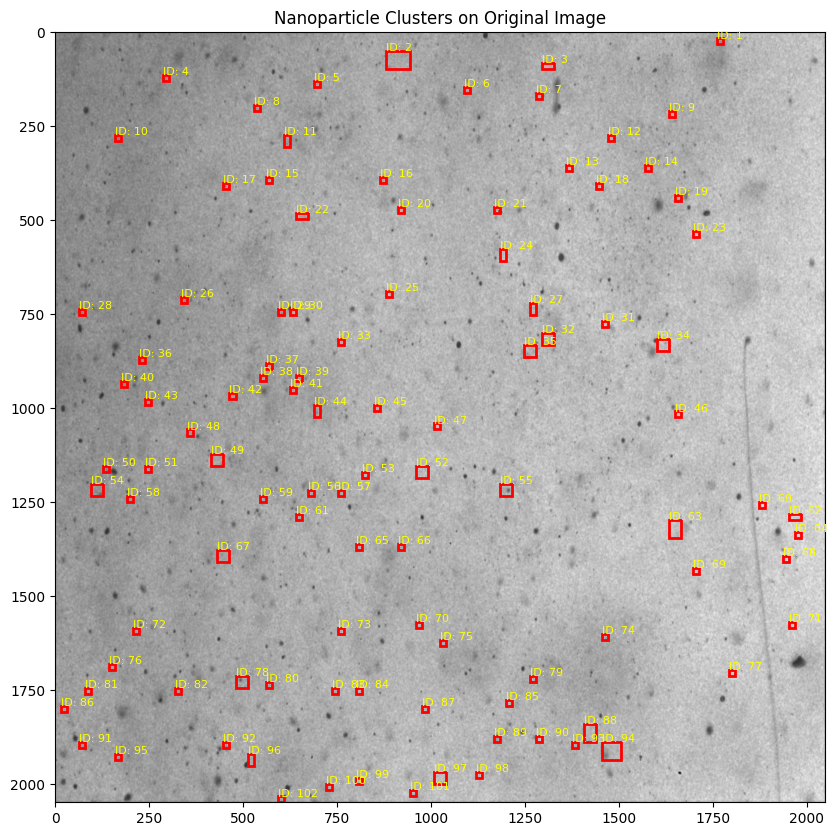

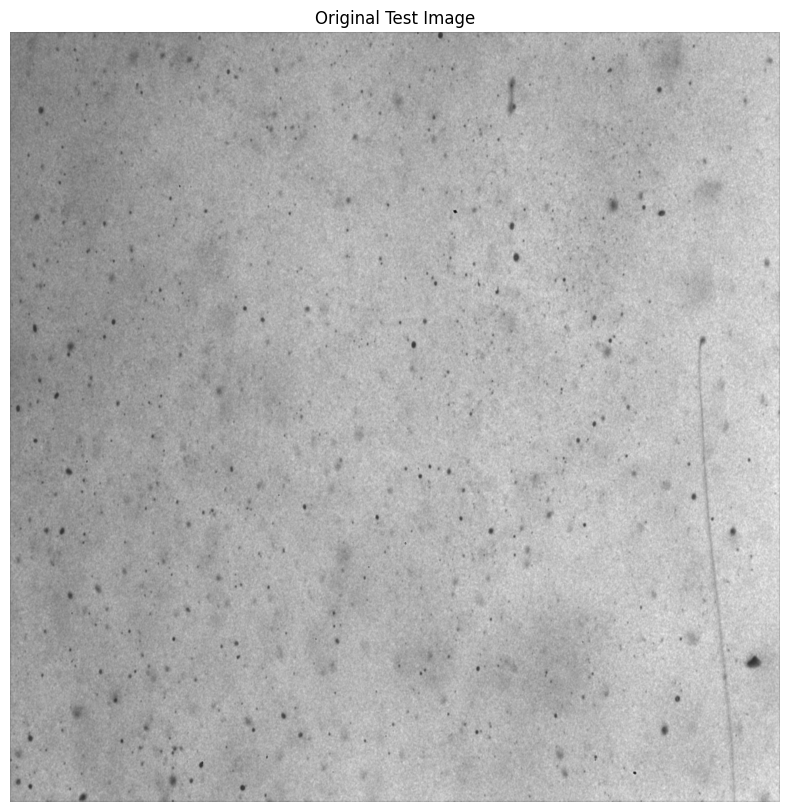

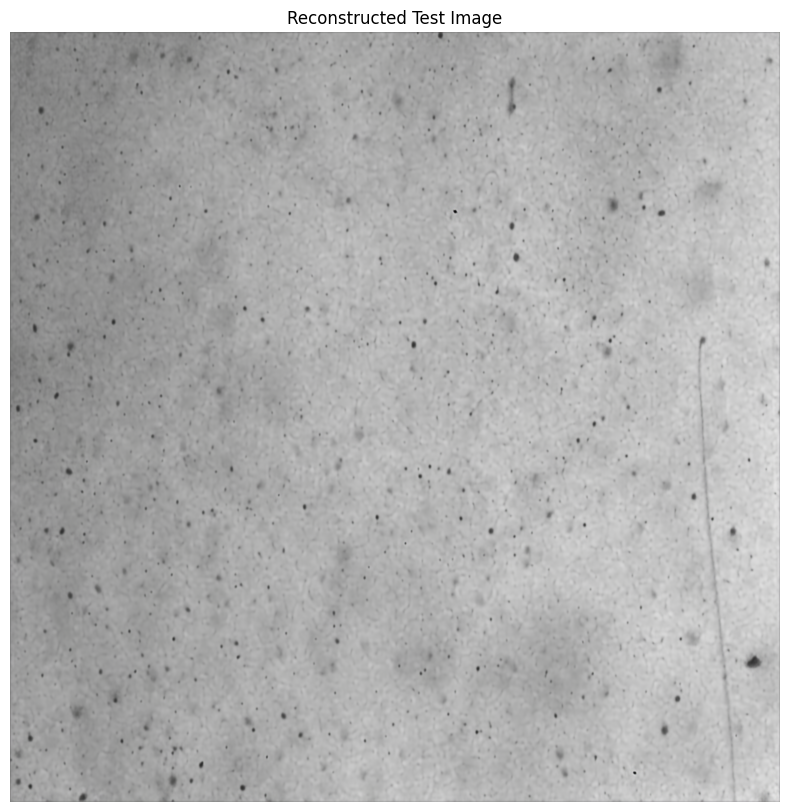

In [26]:
PATCH_SIZE = 16

def extract_patches(image, patch_size=PATCH_SIZE):
    patches = []
    _, height, width = image.shape
    for i in range(0, height, patch_size):
        for j in range(0, width, patch_size):
            patch = image[:, i:i + patch_size, j:j + patch_size]
            if patch.shape[1] == patch_size and patch.shape[2] == patch_size:  # Only full patches
                patches.append(patch)
    return patches

def extract_latent_representations_for_patches(data_loader, patch_size=PATCH_SIZE):
    autoencoder.eval()
    latent_representations = []
    patch_coordinates = []
    with torch.no_grad():
        for img in data_loader:
            img = img[0].to(device) 
            patches = extract_patches(img, patch_size)
            for idx, patch in enumerate(patches):
                patch = patch.unsqueeze(0).to(device)  # add batch dimension
                latent_vector = autoencoder.encode(patch)
                latent_representations.append(latent_vector.cpu().numpy())
                patch_coordinates.append((idx, img.shape[1], img.shape[2]))  # track position for reconstruction
    return np.concatenate(latent_representations), patch_coordinates

def visualize_clusters(img, patch_coordinates, cluster_labels, patch_size=PATCH_SIZE):
    height, width = img.shape[1], img.shape[2]
    clustered_image = np.zeros((height, width))
    num_patches_w = width // patch_size  # Number of patches per row

    for idx, (coord, h, w) in enumerate(patch_coordinates):
        # Calculate row and column index based on the patch index and image width
        i = (coord // num_patches_w) * patch_size
        j = (coord % num_patches_w) * patch_size
        clustered_image[i:i + patch_size, j:j + patch_size] = cluster_labels[idx]
    
    plt.figure(figsize=(10, 10))
    plt.imshow(clustered_image, cmap="viridis")
    plt.colorbar()
    plt.title("Nanoparticle Clusters")
    plt.show()
    return clustered_image

def handle_edge_case(clustered_image, patch_size=PATCH_SIZE):
    """
    Handle edge cases where particles span across patch boundaries.
    """
    height, width = clustered_image.shape
    merged_mask = np.zeros_like(clustered_image)

    for i in range(0, height, patch_size):
        for j in range(0, width, patch_size):
            patch = clustered_image[i:i + patch_size, j:j + patch_size]
            
            for di, dj in [(0, patch_size), (patch_size, 0), (patch_size, patch_size)]:
                ni, nj = i + di, j + dj
                if ni < height and nj < width:
                    neighbor_patch = clustered_image[ni:ni + patch_size, nj:nj + patch_size]
                    # Merge regions if the cluster labels match
                    if np.any(patch == neighbor_patch):
                        # Create a binary mask for merging
                        binary_patch = patch > 0
                        binary_neighbor = neighbor_patch > 0
                        merged_binary = binary_dilation(binary_patch | binary_neighbor)
                        merged_mask[i:i + patch_size, j:j + patch_size] = merged_binary
    
    labeled_clusters, num_particles = label(merged_mask, return_num=True)
    return labeled_clusters, num_particles

def visualize_particles_on_original_image(original_img, labeled_clusters):
    # Convert image tensor to numpy array for plotting
    original_img = original_img.permute(1, 2, 0).cpu().numpy()
    
    # Plot the original image
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.imshow(original_img, cmap="gray")
    ax.set_title("Nanoparticle Clusters on Original Image")
    
    # Find and draw bounding boxes for each detected particle region
    for region in regionprops(labeled_clusters):
        # Ensure the region has a non-zero area
        if region.area > 0:
            # Get bounding box coordinates (min row, min col, max row, max col)
            minr, minc, maxr, maxc = region.bbox
            # Draw the rectangle around the particle region
            rect = patches.Rectangle((minc, minr), maxc - minc, maxr - minr, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            # Optionally, add a label for each particle
            ax.text(minc, minr, f"ID: {region.label}", color="yellow", fontsize=8)
    
    plt.show()

def display_image(tensor, title="Image"):
    img = tensor.cpu().detach().permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis("off")
    plt.title(title)
    plt.show()

def overlay_clusters_on_original(original_img, clustered_image):
    """
    Overlay clusters from the clustered_image onto the original image.
    """
    # Convert the original image tensor to a numpy array
    original_img = original_img.permute(1, 2, 0).cpu().numpy()
    
    # Normalize the original image for better contrast (if required)
    #original_img = (original_img - original_img.min()) / (original_img.max() - original_img.min())
    
    # Plot the original image
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.imshow(original_img, cmap="gray")
    ax.set_title("Overlayed Clusters on Original Image")
    
    # Find and draw contours around each cluster in the clustered image
    unique_clusters = np.unique(clustered_image)
    for cluster_label in unique_clusters:
        if cluster_label == 0:
            # Skip background or clusters labeled as zero
            continue
        mask = (clustered_image == cluster_label).astype(np.uint8)
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for contour in contours:
            # Draw contours in red for each cluster
            ax.plot(contour[:, 0, 0], contour[:, 0, 1], color='r', linewidth=1.5)
            # Optionally add labels
            M = cv2.moments(mask)
            if M["m00"] != 0:  # Avoid division by zero
                cX = int(M["m10"] / M["m00"])
                cY = int(M["m01"] / M["m00"])
                ax.text(cX, cY, f"{cluster_label}", color="yellow", fontsize=8)
    
    #plt.axis("off")
    plt.show()

latent_representations, patch_coordinates = extract_latent_representations_for_patches(test, patch_size=PATCH_SIZE)

# Apply K-means clustering on latent representations
num_clusters = 20
kmeans = KMeans(n_clusters=num_clusters)
cluster_labels = kmeans.fit_predict(latent_representations)

# Extract the centroids of the original 20 clusters
original_centroids = kmeans.cluster_centers_

# Apply K-means with 2 clusters on the centroids
kmeans_2 = KMeans(n_clusters=2, random_state=42)
centroid_labels = kmeans_2.fit_predict(original_centroids)

# Map the original cluster labels to 2 groups (particle or background)
# Assume that cluster label 1 represents particles
particle_group_label = 1
particle_clusters = [i for i, label in enumerate(centroid_labels) if label == particle_group_label]

# Convert cluster_labels to binary particle/non-particle labels
binary_cluster_labels = [1 if cluster_labels[i] in particle_clusters else 0 for i in range(len(cluster_labels))]

sample_img = next(iter(test)).to(device)
clustered_image = visualize_clusters(sample_img[0].cpu(), patch_coordinates, binary_cluster_labels)
# Overlay clusters on the original image
overlay_clusters_on_original(sample_img[0], clustered_image)

# Apply edge case handling
labeled_clusters, num_nanoparticles = handle_edge_case(clustered_image)

visualize_particles_on_original_image(sample_img[0], labeled_clusters)

# Reconstruct and display the original and autoencoder images
with torch.no_grad():
    reconstructed_img = autoencoder(sample_img)

reconstructed_img = torch.clamp(reconstructed_img, 0, 1)

display_image(sample_img[0], title="Original Test Image")
display_image(reconstructed_img[0], title="Reconstructed Test Image")